In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))

print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(3678, 24)
(3678, 3)


In [6]:
X_motion_CoM[0, :]

array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23606978356838226,
       0.1367112398147583, -0.37990203499794006, 0.2484574019908905,
       -0.12517616152763367, -0.37155449390411377, -0.2502307891845703,
       0.13091930747032166, -0.37352049350738525, -0.2601171135902405,
       -0.12646298110485077, -0.38600054383277893, 0.014809110201895237,
       -0.0365188904106617, -0.020871445536613464, 0.0034807350020855665,
       True, False], dtype=object)

# Multivariate Linear Regression (Foot prediction)

In [7]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [8]:
# Entries where FL foot is swinging
idx_fl_rr_swinging = np.where(X_motion_CoM[:, -2] == 1)[0]
X_motion_CoM_FL_RR = X_motion_CoM[idx_fl_rr_swinging]
Y_motion_CoM_FL_RR = Y_motion_CoM[idx_fl_rr_swinging]

In [9]:
idx_fl_rr_swinging.shape

(1845,)

In [10]:
X_motion_CoM_FL_RR[0, :]

array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23606978356838226,
       0.1367112398147583, -0.37990203499794006, 0.2484574019908905,
       -0.12517616152763367, -0.37155449390411377, -0.2502307891845703,
       0.13091930747032166, -0.37352049350738525, -0.2601171135902405,
       -0.12646298110485077, -0.38600054383277893, 0.014809110201895237,
       -0.0365188904106617, -0.020871445536613464, 0.0034807350020855665,
       True, False], dtype=object)

In [11]:
Y_motion_CoM_FL_RR[0, :]

array([0.003430677543864391, -0.005200177420010332, 0.005757652830186866],
      dtype=object)

## Predict CoM -> x

### Linear Regression

In [31]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, 3:6], # Current motion command
               #X_motion_CoM_FL_RR[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_CoM_FL_RR[:, 6:8], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 15:17])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_x = LinearRegression()

# Fit the model
model_fl_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9279167067581424
RMSE:  0.018644095678892473
The lowest error is:  1.0106154666789102e-05
The highest error is:  0.15289210736193648
The avg. error is:  0.011635013004066245


In [32]:
model_fl_com_x.coef_

array([[ 6.66322161e-02,  8.32667268e-16,  1.11022302e-16,
         1.25720867e-01,  1.66533454e-16, -2.22044605e-16,
         3.24126863e-01, -5.88653351e-01,  1.19297730e+00,
         6.62317918e-02, -1.03613129e+00, -3.33800555e-01,
        -9.54747461e-01,  4.15438972e-01]])

In [33]:
model_fl_com_x.intercept_

array([-0.69347558])

In [15]:
input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0,0.2399, 0.134, 0.2399, -0.134, -0.2399, 0.134, -0.2399, -0.134]])
input_ @ model_fl_com_x.coef_.T + model_fl_com_x.intercept_

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 16 is different from 14)

Text(0, 0.5, 'Predictions')

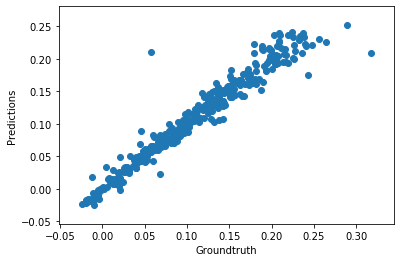

In [16]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [17]:
#%store model_fl_com_x

In [18]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [19]:
# Save model
#joblib.dump(model_fl_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_x.sav")

## Predict CoM -> y

### Linear Regression

In [34]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, 3:6], # Current motion command
               #X_motion_CoM_FL_RR[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_CoM_FL_RR[:, 6:8], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 15:17])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_y = LinearRegression()

# Fit the model
model_fl_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.42405485723683656
RMSE:  0.004397002687167486
The lowest error is:  3.295396355945668e-05
The highest error is:  0.03269878044769142
The avg. error is:  0.003023152392921305


In [35]:
model_fl_com_y.coef_

array([[ 3.98780137e-03,  2.60208521e-16,  6.93889390e-17,
         1.13609441e-02,  0.00000000e+00, -5.55111512e-17,
         2.59657818e-01, -3.78959503e-01,  1.80363451e-01,
         1.84960451e-01, -2.94571354e-01,  1.35783713e-01,
        -3.92040916e-01, -2.69581716e-01]])

In [36]:
model_fl_com_y.intercept_

array([-0.26279804])

Text(0, 0.5, 'Predictions')

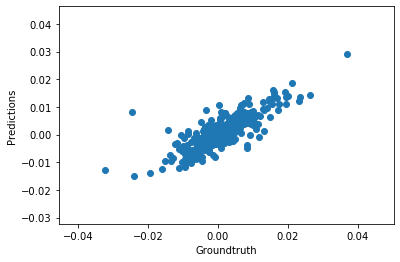

In [37]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [24]:
#%store model_fl_com_y

In [25]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [26]:
# Save model
#joblib.dump(model_fl_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_y.sav")

## Predict CoM -> Yaw

In [38]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, 3:6], # Current motion command
               #X_motion_CoM_FL_RR[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_CoM_FL_RR[:, 6:8], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 15:17])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_theta = LinearRegression()

# Fit the model
model_fl_com_theta.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_theta.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.07723089525172322
RMSE:  0.0026765244110813643
The lowest error is:  5.057750860737453e-06
The highest error is:  0.012535710874300457
The avg. error is:  0.002130360351348085


In [39]:
model_fl_com_theta.coef_

array([[-1.12684884e-04, -6.93889390e-18, -3.81639165e-17,
        -2.88428471e-03, -3.46944695e-17,  4.16333634e-17,
         7.00417178e-02,  8.76459516e-02,  1.81544681e-01,
         9.40326610e-02, -1.80010043e-01, -1.26990207e-01,
        -2.54071509e-02, -7.31995267e-02]])

In [40]:
model_fl_com_theta.intercept_

array([-0.10375172])

Text(0, 0.5, 'Predictions')

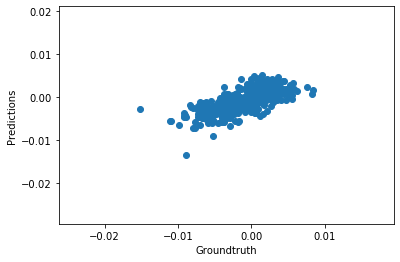

In [30]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")